In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch as th
from conceptual import experiment, generate_bandlimited_experiment_data
from torch_gfrft import EigvalSortStrategy
from torch_gfrft.gfrft import GFRFT
from torch_gfrft.gft import GFT
from utils import (
    complex_round,
    init_knn_from_mat,
    mse_loss,
    seed_everything,
    snr,
    sort_graph_and_jtv,
    symmetric_degree_normalize,
)

plt.rc("text", usetex=True)
plt.rc("font", family="serif")

## Graph & JTV Signal Settings

In [2]:
SEED = 0
NODE_DIM = 0
KNN_COUNT = 10
KNN_SIGMA = None
MAX_NODE_COUNT = 100
MAX_TIME_LENGTH = 120
EIGVAL_SORT_STRATEGY = EigvalSortStrategy.TOTAL_VARIATION
NORMALIZE_JTV_SIGNAL = True
NORMALIZE_SHIFT_MATRIX = True
GRAPH_VERBOSE = True
DEVICE = th.device("cuda" if th.cuda.is_available() else "cpu")
SORT = True

Dataset Info:
	name: sea-surface-temperature
	node count: 100
	time length: 120
JTV Signal: min=0.0, max=1.0


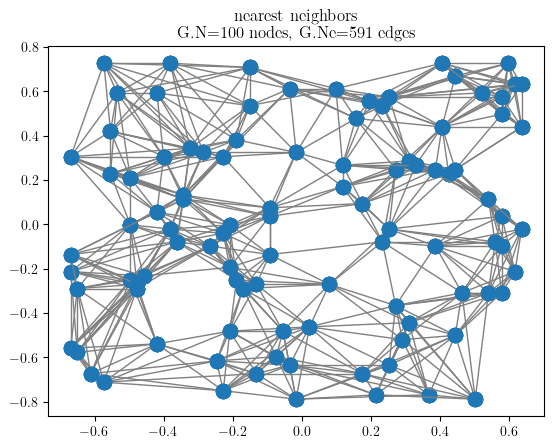

In [3]:
seed_everything(SEED)
datasets_path = Path.cwd().parent.joinpath("data", "tv-graph-datasets").absolute()
curr_dataset_path = datasets_path.joinpath("sea-surface-temperature.mat")
graph, adjacency, jtv_signal = init_knn_from_mat(
    curr_dataset_path,
    knn_count=KNN_COUNT,
    knn_sigma=KNN_SIGMA,
    max_node_count=MAX_NODE_COUNT,
    max_time_length=MAX_TIME_LENGTH,
    device=DEVICE,
    verbose=GRAPH_VERBOSE,
)

if SORT:
    graph, adjacency, jtv_signal = sort_graph_and_jtv(
        graph,
        adjacency,
        jtv_signal,
        lambda x: x[0] + x[1],  # sort by coordinates
    )

if NORMALIZE_SHIFT_MATRIX:
    adjacency = symmetric_degree_normalize(adjacency)

if NORMALIZE_JTV_SIGNAL:
    jtv_signal = (jtv_signal - jtv_signal.min()) / (jtv_signal.max() - jtv_signal.min())

print(f"JTV Signal: min={jtv_signal.min()}, max={jtv_signal.max()}")
gft = GFT(adjacency, EIGVAL_SORT_STRATEGY)
gfrft = GFRFT(gft.gft_mtx)

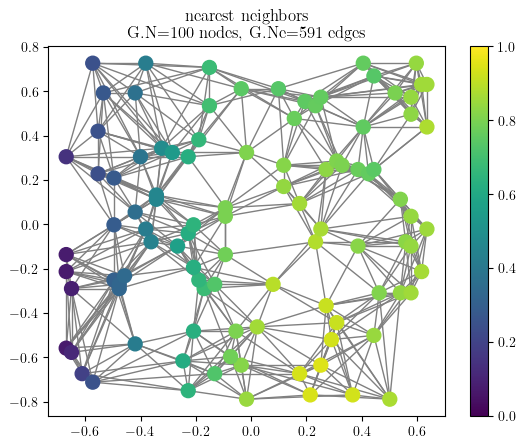

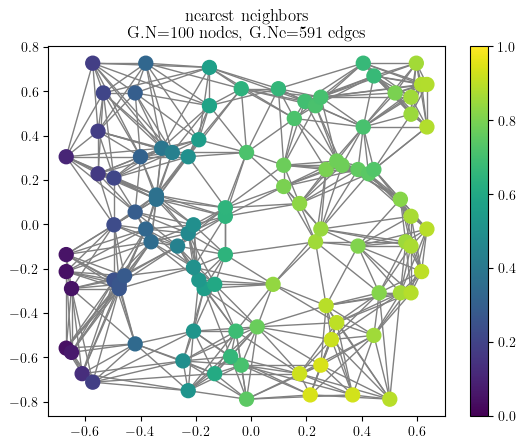

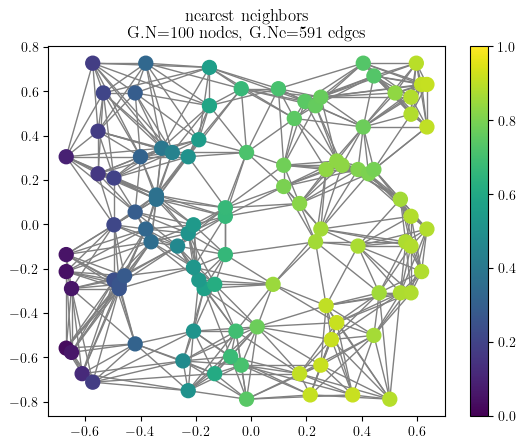

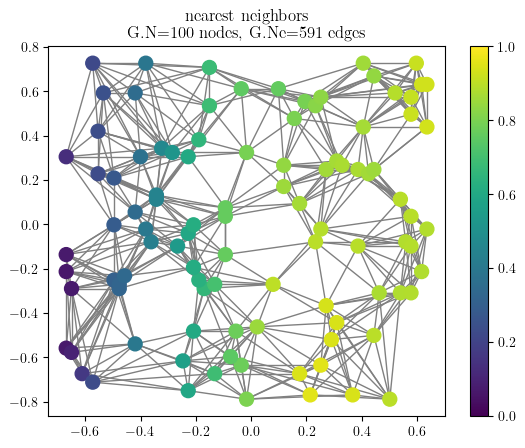

In [4]:
def display_jtv_signal(graph, jtv_signal, time_instances: list[int]) -> None:
    limits = [jtv_signal.min().floor().item(), jtv_signal.max().ceil().item()]
    for t in set(time_instances):
        gsignal = jtv_signal[..., t]
        graph.plot_signal(gsignal.cpu().numpy(), limits=limits)


display_jtv_signal(graph, jtv_signal, [0, 5, 10, 15])

In [5]:
def print_pre_info(bl_signal: th.Tensor, bl_noise: th.Tensor) -> None:
    bl_noisy_signal = bl_signal + bl_noise
    print(f"SNR: {snr(bl_signal, bl_noise):.2f}")
    print(f"MSE: {mse_loss(bl_signal, bl_noisy_signal):.2e}")


def print_after_info(model: th.nn.Module, bl_signal: th.Tensor, bl_noise: th.Tensor) -> None:
    bl_noisy_signal = bl_signal + bl_noise
    with th.no_grad():
        estimated_signal = model(bl_noisy_signal)

    initial_mse = mse_loss(bl_signal, bl_noisy_signal)
    estimated_mse = mse_loss(bl_signal, estimated_signal)

    initial_snr = snr(bl_signal, bl_noisy_signal - bl_signal)
    estimated_snr = snr(bl_signal, estimated_signal - bl_signal)

    print(f"Initial SNR/MSE: {initial_snr:.2f}/{initial_mse:.2e}")
    print(f"Estimated SNR/MSE: {estimated_snr:.2f}/{estimated_mse:.2e}")

In [6]:
# Data generation
ORIGINAL_ORDER = 0.45
STOPBAND_COUNT = 30
OVERLAP_COUNT = 0
NOISE_MEAN = 0.0
NOISE_SIGMA = 0.5

# Model
INITIAL_ORDERS = [1.0]
CUTOFF_COUNTS = [STOPBAND_COUNT]
LEARNING_RATE = 5e-3
EPOCHS = 2000
TRAINABLE_TRANSFORM = True
TRAINABLE_FILTER = False

bl_signal, bl_noise = generate_bandlimited_experiment_data(
    gfrft=gfrft,
    signal=jtv_signal,
    order=ORIGINAL_ORDER,
    stopband_count=STOPBAND_COUNT,
    overlap=OVERLAP_COUNT,
    mean=NOISE_MEAN,
    sigma=NOISE_SIGMA,
)

print_pre_info(bl_signal, bl_noise)
model = experiment(
    gfrft=gfrft,
    jtv_signal=bl_signal,
    jtv_noise=bl_noise,
    initial_orders=INITIAL_ORDERS,
    cutoff_counts=CUTOFF_COUNTS,
    lr=LEARNING_RATE,
    epochs=EPOCHS,
    display_epochs=list(range(0, EPOCHS + 1, EPOCHS // 10)),
    trainable_transform=TRAINABLE_TRANSFORM,
    trainable_filter=TRAINABLE_FILTER,
    seed=SEED,
)
print(model)
print_after_info(model, bl_signal, bl_noise)

SNR: 6.75
MSE: 7.54e-02
Sequential(
  (0): GFRFTFilter(order=1.0 (trainable), filter=cutoff=30)
  (1): Real()
)
learning rate: 0.005


Initial Loss 0.07544 | SNR 6.748:   0%|          | 0/2000 [00:00<?, ?it/s]

Sequential(
  (0): GFRFTFilter(order=0.44999995827674866 (trainable), filter=cutoff=30)
  (1): Real()
)
Initial SNR/MSE: 6.75/7.54e-02
Estimated SNR/MSE: 146.62/7.77e-16


Initial SNR: 5.38, Filtered SNR: 142.17


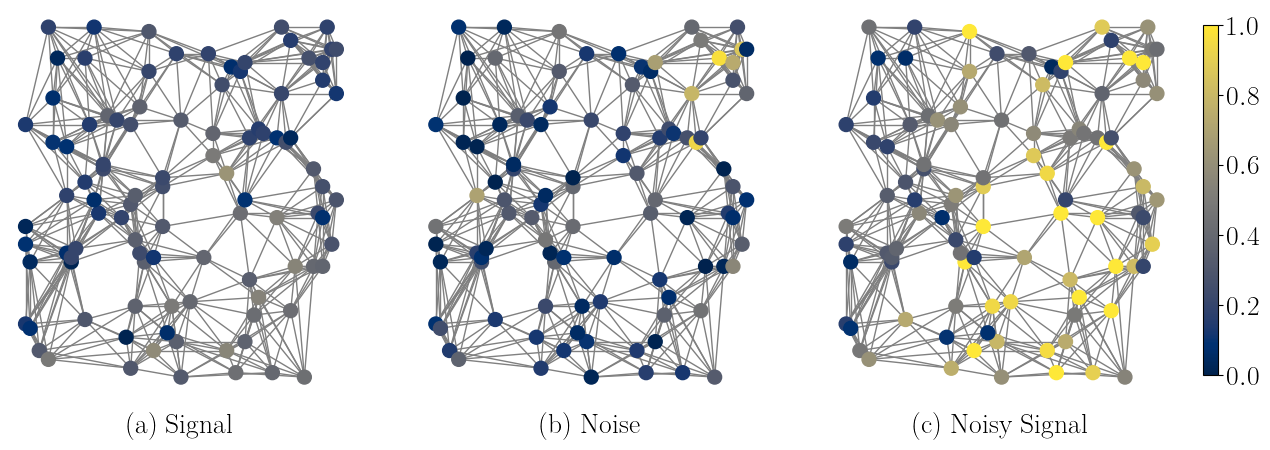

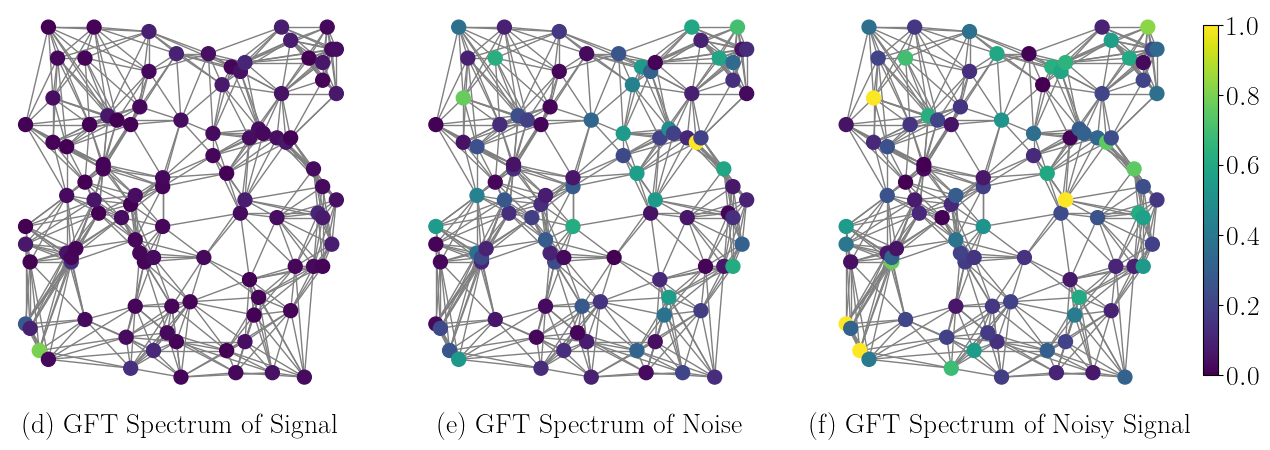

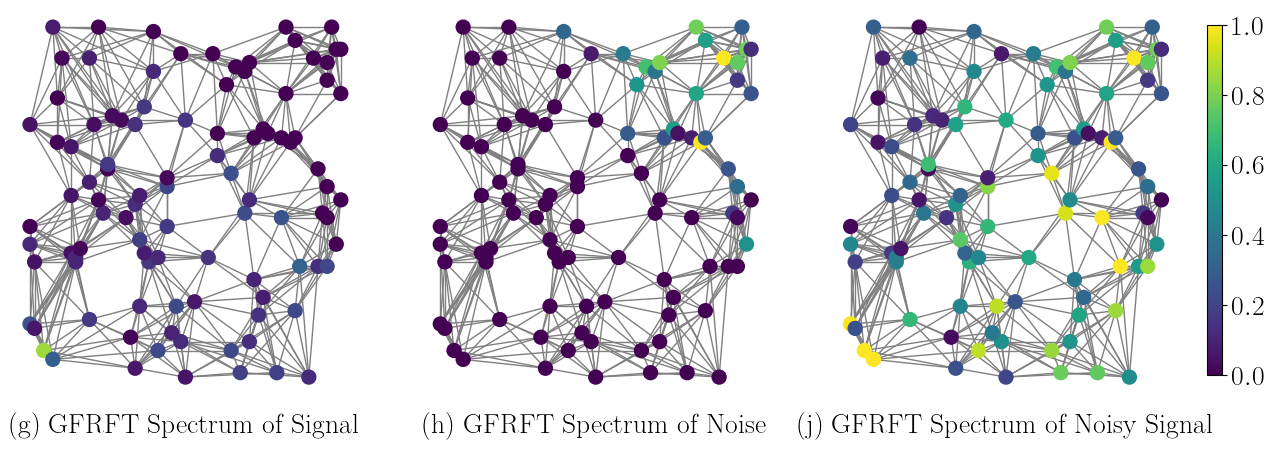

In [7]:
def my_plot(
    signals: list[th.Tensor],
    labels: list[str],
    out_name: str,
    cmp: str,
    highlight=None,
    normalize: bool = False,
) -> None:
    min_limit = min([tensor.abs().min().floor().item() for tensor in signals])
    max_limit = max(tensor.abs().max().ceil().item() for tensor in signals)
    limits = [min_limit, max_limit]

    plt.rcParams["image.cmap"] = cmp
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for i, (ax, sig, label) in enumerate(zip(axs, signals, labels)):
        psignal = sig.abs().cpu().numpy()
        if normalize:
            psignal = psignal / max_limit
            min_limit, max_limit = 0, 1
            limits = [min_limit, max_limit]
        graph.plot_signal(
            psignal,
            limits=limits,
            colorbar=False,
            highlight=[] if highlight is None or i != len(labels) - 1 else highlight,
            # highlight=[] if highlight is None else highlight,
            ax=ax,
        )
        plt.title("")
        plt.axis("off")
        ax.set_title("")  # Remove the title
        ax.axis("off")  # Remove the axes
        ax.annotate(label, xy=(0.5, -0.1), xycoords="axes fraction", ha="center", fontsize=20)

    cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])  # [left, bottom, width, height]
    sm = plt.cm.ScalarMappable(cmap=cmp, norm=plt.Normalize(vmin=min_limit, vmax=max_limit))  # type: ignore
    fig.colorbar(sm, cax=cbar_ax)
    cbar_ax.tick_params(labelsize=20)
    plt.savefig(out_name, format="eps", dpi=300, bbox_inches="tight")


def display_bl_signal(
    gfrft: GFRFT,
    graph,
    signal: th.Tensor,
    noise: th.Tensor,
    filtered: th.Tensor,
    order: float,
    decimals: int = 7,
    normalize: bool = False,
) -> None:
    original_signals = [signal, noise, signal + noise]
    ordinary_transforms = [
        complex_round(gfrft.gfrft(x, a=1.00), decimals) for x in original_signals
    ]
    fractional_transforms = [
        complex_round(gfrft.gfrft(x, a=order), decimals) for x in original_signals
    ]

    signal_cmp, transform_cmp = "cividis", "viridis"
    signal_labels = [
        r"(a) Signal",
        r"(b) Noise",
        r"(c) Noisy Signal",
    ]
    ordinary_labels = [
        r"(d) GFT Spectrum of Signal",
        r"(e) GFT Spectrum of Noise",
        r"(f) GFT Spectrum of Noisy Signal",
    ]
    transform_labels = [
        r"(g) GFRFT Spectrum of Signal",
        r"(h) GFRFT Spectrum of Noise",
        r"(j) GFRFT Spectrum of Noisy Signal",
    ]

    my_plot(original_signals, signal_labels, "signals.eps", signal_cmp, normalize=normalize)
    my_plot(
        ordinary_transforms,
        ordinary_labels,
        "ordinary_transforms.eps",
        transform_cmp,
        normalize=normalize,
    )
    highlight_band = list(range(graph.N - OVERLAP_COUNT - STOPBAND_COUNT, graph.N - STOPBAND_COUNT))
    my_plot(
        fractional_transforms,
        transform_labels,
        "fractional_transforms.eps",
        transform_cmp,
        highlight_band,
        normalize=normalize,
    )


index = 10
decimals = 7
with th.no_grad():
    bl_filtered = model(bl_signal + bl_noise)
signal = complex_round(bl_signal[..., index], decimals)
noise = complex_round(bl_noise[..., index], decimals)
filtered = complex_round(bl_filtered[..., index], decimals)
display_bl_signal(gfrft, graph, signal, noise, filtered, ORIGINAL_ORDER, decimals, normalize=True)
print(f"Initial SNR: {snr(signal, noise):.2f}, Filtered SNR: {snr(signal, filtered - signal):.2f}")

In [8]:
signal_ordinary_spectrum = gft.gft(signal)
noise_ordinary_spectrum = gft.gft(noise)
signal_fractional_spectrum = gfrft.gfrft(signal, a=ORIGINAL_ORDER)
noise_fractional_spectrum = gfrft.gfrft(noise, a=ORIGINAL_ORDER)

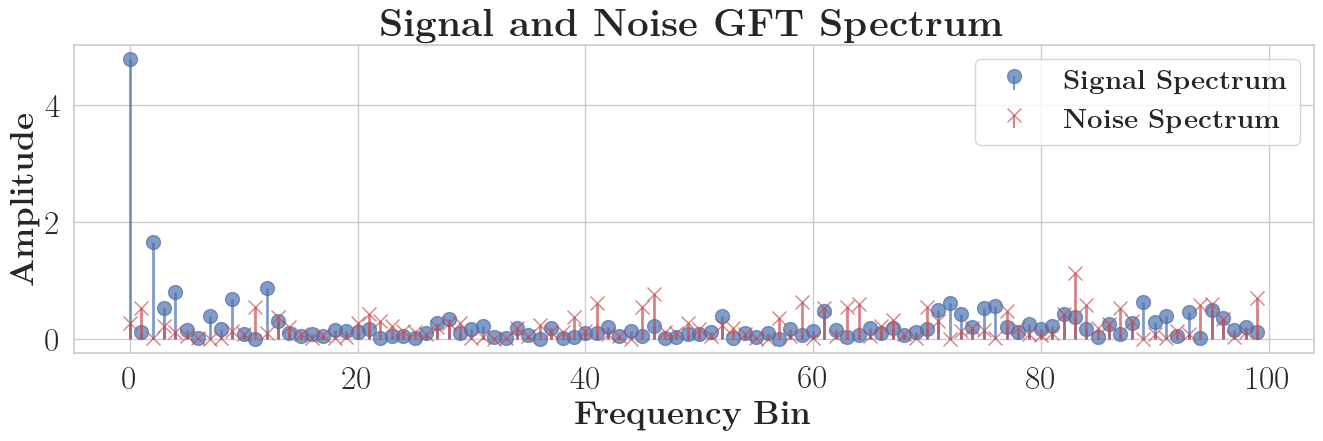

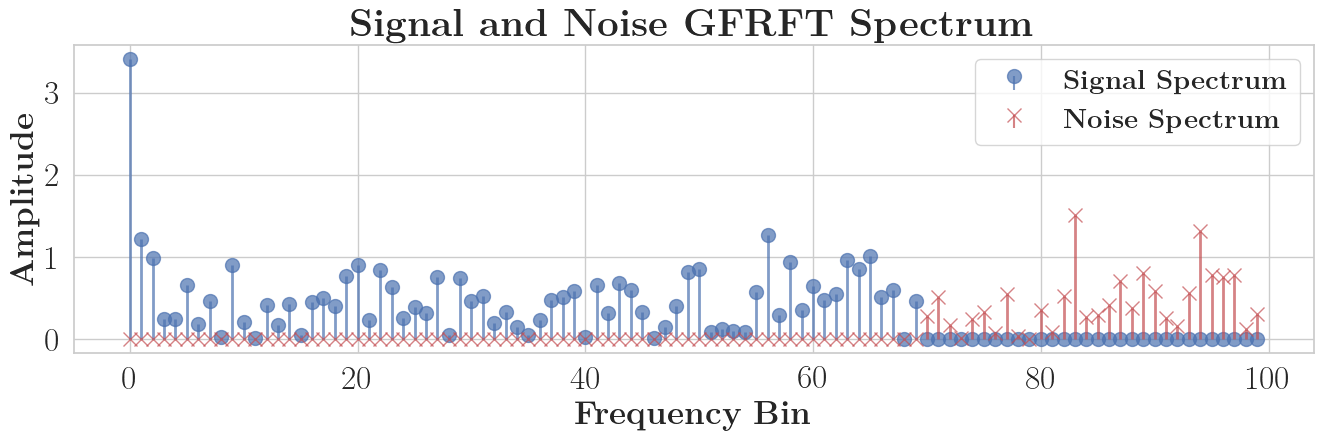

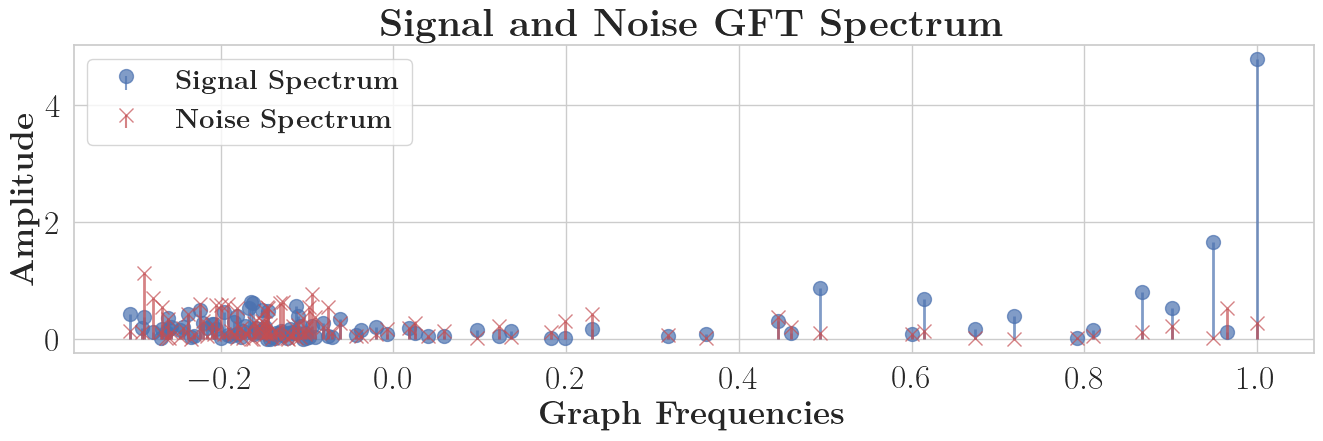

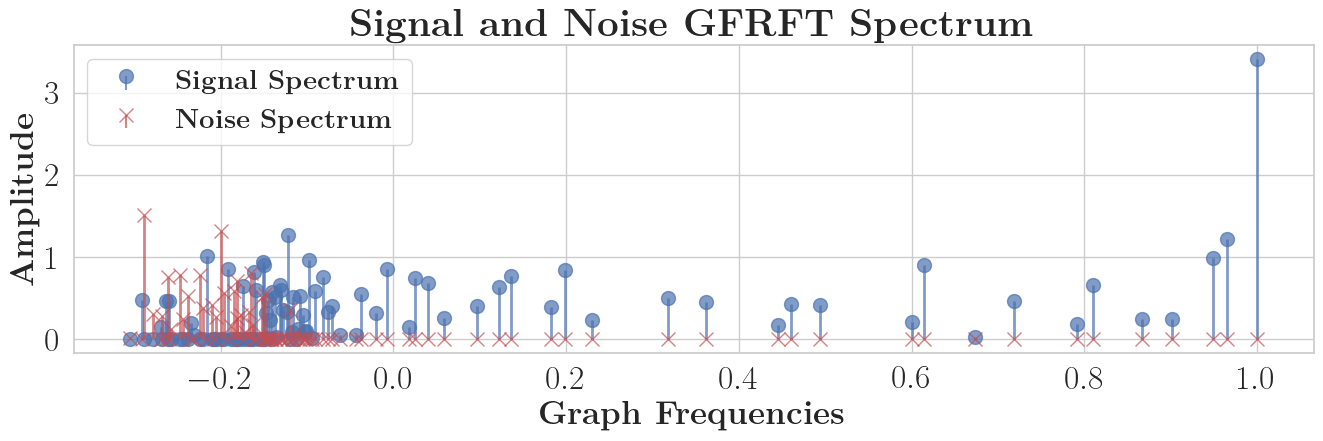

In [9]:
sns.set_theme(style="whitegrid")
plt.rc("text", usetex=True)
plt.rc("font", family="serif")


def plot_spectrum(
    signal_spectrum: np.ndarray,
    noise_spectrum: np.ndarray,
    out_name: str,
    spectrum: np.ndarray | None = None,
    title: str = "",
) -> None:
    use_graph_freqs = spectrum is not None
    if not use_graph_freqs:
        spectrum = np.array(range(len(signal_spectrum)))

    fig, ax = plt.subplots(figsize=(16, 4))
    signal_markerline, signal_stemlines, signal_baseline = ax.stem(
        spectrum, signal_spectrum, linefmt="C0-", markerfmt="C0o", basefmt=" "
    )
    noise_markerline, noise_stemlines, noise_baseline = ax.stem(
        spectrum, noise_spectrum, linefmt="r-", markerfmt="rx", basefmt=" "
    )

    plt.setp(signal_markerline, markersize=10, alpha=0.7)  # Increase marker size
    plt.setp(signal_stemlines, linewidth=2, alpha=0.7)  # Increase line width
    plt.setp(noise_markerline, markersize=10, alpha=0.7)  # Increase marker size
    plt.setp(noise_stemlines, linewidth=2, alpha=0.7)  # Increase line width
    ax.set_title(r"\textbf{Signal and Noise " + f"{title}" + " Spectrum}", fontsize=28)
    if use_graph_freqs:
        ax.set_xlabel(r"\textbf{Graph Frequencies}", fontsize=24)
    else:
        ax.set_xlabel(r"\textbf{Frequency Bin}", fontsize=24)
    ax.set_ylabel(r"\textbf{Amplitude}", fontsize=24)
    ax.legend(
        [r"\textbf{Signal Spectrum}", r"\textbf{Noise Spectrum}"],
        loc="best",
        fontsize=20,
    )
    ax.tick_params(axis="both", which="major", labelsize=24)
    fig.savefig(out_name, format="png", dpi=300, bbox_inches="tight")


for use_graph_freqs in [False, True]:
    spectrum = gft.graph_freqs.cpu().numpy() if use_graph_freqs else None
    ordinary_out = "ordinary_spectrum_freqs.png" if use_graph_freqs else "ordinary_spectrum.png"
    plot_spectrum(
        signal_ordinary_spectrum.abs().cpu().numpy(),
        noise_ordinary_spectrum.abs().cpu().numpy(),
        out_name=ordinary_out,
        spectrum=spectrum,
        title="GFT",
    )
    fractional_out = (
        "fractional_spectrum_freqs.png" if use_graph_freqs else "fractional_spectrum.png"
    )
    plot_spectrum(
        signal_fractional_spectrum.abs().cpu().numpy(),
        noise_fractional_spectrum.abs().cpu().numpy(),
        out_name=fractional_out,
        spectrum=spectrum,
        title="GFRFT",
    )